<a href="https://colab.research.google.com/github/matsunagalab/tutorial_analyzingMDdata/blob/main/md_dimensionalreduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensional reduction

## MDTrajのインストール

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge mdtraj

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2



# All requested packages already installed.



## T4 LysozymeのMDデータの取得

比較のために wildtype と mutant 関連のデータをダウンロードする。

In [3]:
!gdown 1Lu22Z7ARKSws77sBaYr84iCcQsnTHId9
!gdown 1GeXp7pbLO8nuK5L6x1xzxj1AX6kMnXy6
!gdown 1G_dnmdjgKFr-O8ciNo5JVR9iN4FQBAAE

!gdown 1Lwx8zhPSBMApi94QZtpLW7pMUzj2wDhv
!gdown 1GbwP2NbHn4QMDFTanhpFwdvnUz2EPOMn
!gdown 1G_8UijRvld_-Df5OU4I3fNn8URpDtf54

Downloading...
From: https://drive.google.com/uc?id=1Lu22Z7ARKSws77sBaYr84iCcQsnTHId9
To: /content/wildtype.pdb
100% 209k/209k [00:00<00:00, 21.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GeXp7pbLO8nuK5L6x1xzxj1AX6kMnXy6
To: /content/wildtype.psf
100% 623k/623k [00:00<00:00, 26.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G_dnmdjgKFr-O8ciNo5JVR9iN4FQBAAE
To: /content/wildtype.dcd
100% 215M/215M [00:01<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Lwx8zhPSBMApi94QZtpLW7pMUzj2wDhv
To: /content/mutant.pdb
100% 208k/208k [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GbwP2NbHn4QMDFTanhpFwdvnUz2EPOMn
To: /content/mutant.psf
100% 621k/621k [00:00<00:00, 30.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G_8UijRvld_-Df5OU4I3fNn8URpDtf54
To: /content/mutant.dcd
100% 119M/119M [00:02<00:00, 46.1MB/s]


## 原子座標の主成分分析


In [7]:
import mdtraj as md
import numpy as np

w_ref = md.load('/content/wildtype.pdb')
w = md.load('/content/wildtype.dcd', top='/content/wildtype.psf')

m_ref = md.load('/content/mutant.pdb')
m = md.load('/content/mutant.dcd', top='/content/mutant.psf')

In [8]:
atoms_to_keep = [a.index for a in w.topology.atoms if a.name == 'CA']
w.restrict_atoms(atoms_to_keep)
w_ref.restrict_atoms(atoms_to_keep)

<mdtraj.Trajectory with 1 frames, 164 atoms, 164 residues, without unitcells at 0x7b66f5923ee0>

In [9]:
atoms_to_keep = [a.index for a in m.topology.atoms if a.name == 'CA']
m.restrict_atoms(atoms_to_keep)
m_ref.restrict_atoms(atoms_to_keep)

<mdtraj.Trajectory with 1 frames, 164 atoms, 164 residues, without unitcells at 0x7b671f064d60>

In [11]:
w.superpose(w_ref, 0)
m.superpose(w_ref, 0)

<mdtraj.Trajectory with 3741 frames, 164 atoms, 164 residues, and unitcells at 0x7b670097bfd0>

In [12]:
w.xyz.shape

(6768, 164, 3)

In [14]:
coordinates = np.vstack((w.xyz.reshape(w.n_frames, w.n_atoms*3), m.xyz.reshape(m.n_frames, m.n_atoms*3)))
coordinates.shape

(10509, 492)

In [15]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

pca = PCA()
pca_result = pca.fit_transform(coordinates)

Text(0.5, 1.0, 'PCA scatter plot')

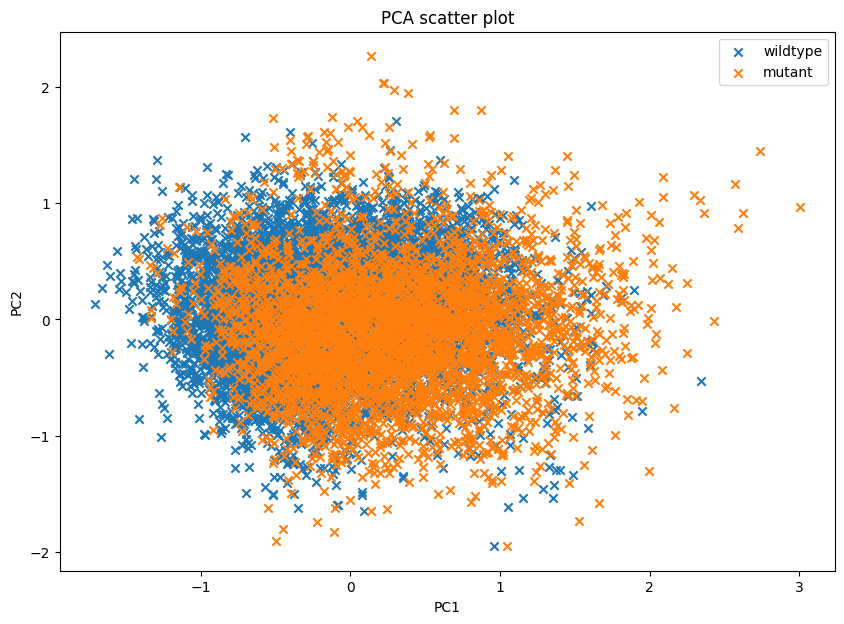

In [18]:
# Plot the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(x=pca_result[:w.n_frames, 0], marker='x', y=pca_result[:w.n_frames, 1], label="wildtype")
plt.scatter(x=pca_result[w.n_frames:, 0], marker='x', y=pca_result[w.n_frames:, 1], label="mutant")
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA scatter plot')

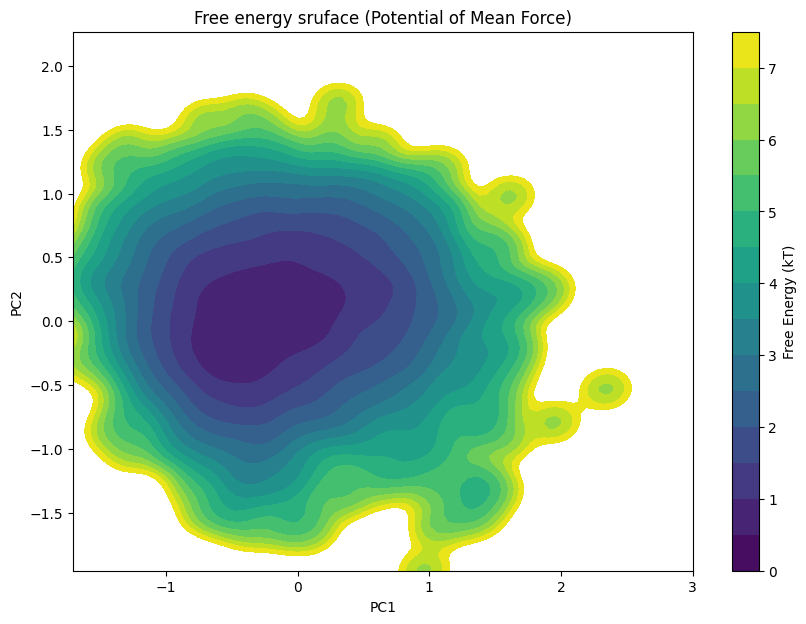

In [19]:
# Calculate the potential of mean force
kde = gaussian_kde(np.vstack([pca_result[:w.n_frames, 0], pca_result[:w.n_frames, 1]]))

# Compute the potential of mean force
x, y = np.mgrid[min(pca_result[:, 0]):max(pca_result[:, 0]):100j,
                min(pca_result[:, 1]):max(pca_result[:, 1]):100j]
positions = np.vstack([x.ravel(), y.ravel()])
pmf = np.reshape(kde(positions), x.shape)

# Plot the potential of mean force as contours on top of the scatter plot
plt.figure(figsize=(10, 7))
plt.contourf(x, y, -np.log(pmf), np.arange(0.0, 8.0, 0.5), cmap='viridis')
plt.colorbar(label='Free Energy (kT)')
plt.title('Free energy sruface (Potential of Mean Force)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
